In [1]:
using OrdinaryDiffEq, SteadyStateDiffEq, ModelingToolkit
using Plots

In [22]:
include("../../src/indexing.jl")
include("../../src/doubleSums.jl")
include("../../src/averageSums.jl")
include("../../src/indexedMeanfield.jl")
include("../../src/indexedScale.jl")

substitute (generic function with 46 methods)

In [3]:
#M = 2 # order
@cnumbers N Δ g κ Γ R ν

# Hilbertspace
hc = FockSpace(:cavity)
ha = NLevelSpace(:atom,3)
#ha = ClusterSpace(ha_, N, M)
h = hc ⊗ ha

ℋ(cavity) ⊗ ℋ(atom)

In [4]:
ind(i) = Index(h,Symbol(i),N)
@qnumbers a::Destroy(h)
σ(i,j,k) = IndexedOperator(Transition(h,:σ,i,j),k)

σ (generic function with 1 method)

In [5]:
i_ind = ind(:i)

Index(ℋ(cavity) ⊗ ℋ(atom), :i, N)

In [6]:
H = -Δ*a'a + g*(IndexedSingleSum(a'*σ(1,2,ind(:i)),ind(:i)) + IndexedSingleSum(a*σ(2,1,ind(:i)),ind(:i)))

(Σ(i=1:N)g*(a′*σ12i)+Σ(i=1:N)g*(a*σ21i)+-Δ*(a′*a))

In [7]:
J = [a,σ(1,2,ind(:k)),σ(2,1,ind(:k)),σ(2,2,ind(:k))]

4-element Vector{QNumber}:
 a
 σ12k
 σ21k
 σ22k

In [8]:
rates = [κ, Γ, R, ν]

4-element Vector{Sym{Parameter, Base.ImmutableDict{DataType, Any}}}:
 κ
 Γ
 R
 ν

In [9]:
ops = [a'*a,σ(2,2,ind(:k))]

2-element Vector{QNumber}:
 (a′*a)
 σ22k

In [10]:
eqs = indexedMeanfield(ops,H,J;rates=rates,order=2)

∂ₜ(⟨a′*a⟩) = (0 + 1im)*var"∑(i=1:N)g*⟨a*σ21i⟩" + (0 - 1im)*var"∑(i=1:N)g*⟨a′*σ12i⟩" - κ*⟨a′*a⟩
∂ₜ(⟨σ22k⟩) = R + (0 + 1im)*g*⟨a′*σ12k⟩ + (0 - 1im)*g*⟨a*σ21k⟩ - R*⟨σ22k⟩ - Γ*⟨σ22k⟩


In [11]:
# custom filter function
φ(x::Average) = φ(x.arguments[1])
φ(::Destroy) = -1
φ(::Create) =1
φ(x::QTerm) = sum(map(φ, x.args_nc))
φ(x::Transition) = x.i - x.j
φ(x::IndexedOperator) = x.op.i - x.op.j
φ(x::IndexedSingleSum) = φ(x.term)
φ(x::SymbolicUtils.Sym{Parameter, IndexedAverageSum}) = φ(x.metadata.term)
φ(x::SymbolicUtils.Sym{Parameter, SpecialIndexedAverage}) = φ(x.metadata.term)
φ(x::SpecialIndexedAverage) = φ(x.term)
phase_invariant(x) = iszero(φ(x))

phase_invariant (generic function with 1 method)

In [23]:
eqs_c = indexedComplete(eqs;filter_func=phase_invariant,extraIndices=[:q])

∂ₜ(⟨a′*a⟩) = (0 + 1im)*var"∑(i=1:N)g*⟨a*σ21i⟩" + (0 - 1im)*var"∑(i=1:N)g*⟨a′*σ12i⟩" - κ*⟨a′*a⟩
∂ₜ(⟨σ22k⟩) = R + (0 + 1im)*g*⟨a′*σ12k⟩ + (0 - 1im)*g*⟨a*σ21k⟩ - R*⟨σ22k⟩ - Γ*⟨σ22k⟩
∂ₜ(⟨a′*σ12k⟩) = (0 + 1im)*var"∑(i=1:N)(i≠k)g*⟨σ21i*σ12k⟩" + (0 + 1im)*g*⟨σ22k⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 - 1im)*Δ*⟨a′*σ12k⟩ + (0 + 2im)*g*⟨σ22k⟩*⟨a′*a⟩ - 0.5R*⟨a′*σ12k⟩ - 0.5Γ*⟨a′*σ12k⟩ - 0.5κ*⟨a′*σ12k⟩ - 0.5ν*⟨a′*σ12k⟩
∂ₜ(⟨σ12k*σ21q⟩) = var"(k≠q)(0 - 1im)*g*⟨a*σ21q⟩" + var"(k≠q)(0 - 1im)*g*⟨σ22q⟩*⟨a′*σ12k⟩" + var"(k≠q)-0.5Γ*⟨σ12k*σ21q⟩" + var"(k≠q)-0.5ν*⟨σ12k*σ21q⟩" + var"(k≠q)0.5R*⟨σ12k*σ21q⟩" + var"(q≠k)(0 + 1im)*g*⟨a′*σ12k⟩" + var"(q≠k)(0 - 1im)*g*⟨σ22q⟩*⟨a′*σ12k⟩" + 2var"(k≠q)(0 + 1im)*g*⟨σ22k⟩*⟨a*σ21q⟩" + 2var"(k≠q)-0.5R*⟨σ12k*σ21q⟩" + (0 + 1im)*var"∑(i=1:N)(i≠k,q)g*⟨a*σ21i⟩*⟨σ12k*σ21q⟩" + (0 + 1im)*var"∑(i=1:N)(i≠k,q)g*⟨a*σ21q⟩*⟨σ21i*σ12k⟩" + (0 + 1im)*var"∑(i=1:N)(i≠k,q)g*⟨a′*σ12i⟩*⟨σ12k*σ21q⟩" + (0 + 1im)*var"∑(i=1:N)(i≠k,q)g*⟨a′*σ12k⟩*⟨σ12i*σ21q⟩" + (0 + 1im)*var"∑(i=1:N)(i≠k,q)g*⟨a′*σ21q⟩*⟨σ12i*σ12k

In [24]:
eqs_sc = scaleME(eqs_c)

∂ₜ(⟨a′*a⟩) = (0 - 1im)*N*g*⟨a′*σ121⟩ + (0 + 1im)*N*g*⟨a*σ211⟩ - κ*⟨a′*a⟩
∂ₜ(⟨σ221⟩) = R + (0 + 1im)*g*⟨a′*σ121⟩ + (0 - 1im)*g*⟨a*σ211⟩ - R*⟨σ221⟩ - Γ*⟨σ221⟩
∂ₜ(⟨a′*σ121⟩) = (0 + 1im)*g*⟨σ221⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 - 1im)*Δ*⟨a′*σ121⟩ + (0 + 1im)*g*(N - 1)*⟨σ211*σ122⟩ + (0 + 2im)*g*⟨σ221⟩*⟨a′*a⟩ - 0.5R*⟨a′*σ121⟩ - 0.5Γ*⟨a′*σ121⟩ - 0.5κ*⟨a′*σ121⟩ - 0.5ν*⟨a′*σ121⟩
∂ₜ(⟨σ121*σ212⟩) = (0 + 1im)*g*⟨a′*σ121⟩ + (0 - 1im)*g*⟨a*σ211⟩ + (0 - 2im)*g*⟨σ221⟩*⟨a′*σ121⟩ + (0 + 2im)*g*⟨σ221⟩*⟨a*σ211⟩ - 0.5R*⟨σ121*σ212⟩ - 0.5Γ*⟨σ121*σ212⟩ - 0.5ν*⟨σ121*σ212⟩


In [14]:
@named sys = ODESystem(eqs_sc)

Model sys with 4 equations
States (4):
  var"⟨a′*a⟩"(t)
  var"⟨σ221⟩"(t)
  var"⟨a′*σ121⟩"(t)
  var"⟨σ121*σ212⟩"(t)
Parameters (7):
  g
  κ
  N
  R
  Γ
  Δ
⋮

In [15]:
# Initial state
u0 = zeros(ComplexF64, length(eqs_c))
# System parameters
N_ = 2e5
Γ_ = 1.0 #Γ=1mHz
Δ_ = 2500Γ_ #Δ=2.5Hz
g_ = 1000Γ_ #g=1Hz
κ_ = 5e6*Γ_ #κ=5kHz
R_ = 1000Γ_ #R=1Hz
ν_ = 1000Γ_ #ν=1Hz

ps = [N, Δ, g, κ, Γ, R, ν]
p0 = [N_, Δ_, g_, κ_, Γ_, R_, ν_]

prob = ODEProblem(sys,u0,(0.0, 1.0/50Γ_), ps.=>p0)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 0.02)
u0: 4-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [16]:
sol = solve(prob,Tsit5(),maxiters=1e7)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 28510-element Vector{Float64}:
 0.0
 6.127395808989627e-7
 8.830740862133526e-7
 1.4177047686494758e-6
 1.9005607308557994e-6
 2.623969770266906e-6
 3.4847101728287696e-6
 4.372839058141698e-6
 5.213744213870986e-6
 5.985506947157479e-6
 6.705877818072669e-6
 7.403681265616978e-6
 8.101326531816264e-6
 ⋮
 0.01999270473887096
 0.01999340596816621
 0.019994107197433594
 0.019994808426626674
 0.01999550965588477
 0.019996210885115002
 0.01999691211441025
 0.019997613343631194
 0.019998314572824274
 0.01999901580208237
 0.019999717031312602
 0.02
u: 28510-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [3.2762752046455582e-6 + 0.0im, 0.0006125516530116635 + 0.0im, 4.4384237532927384e-11 + 1.1726693315618238e-7im, -5.363056716011854e-11 - 2.1842043625703916e-32im]
 [1.090280020071423e-5 + 0.0im, 0.000882683761146331 + 0.0im, 1.0360778729154182e-10 + 2.0417345930761898e-7i

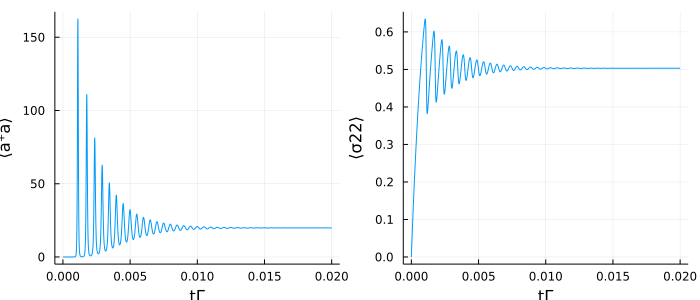

In [17]:
# Plot time evolution
t = sol.t
n = real.(sol[a'a])
s22 = real.(sol[NumberedOperator(Transition(h,:σ,2,2),1)])
# Plot
p1 = plot(t, n, xlabel="tΓ", ylabel="⟨a⁺a⟩", legend=false)
p2 = plot(t, s22, xlabel="tΓ", ylabel="⟨σ22⟩", legend=false)
plot(p1, p2, layout=(1,2), size=(700,300))

In [26]:
corr = CorrelationFunction(a', a, eqs_c; steady_state=true, filter_func=phase_invariant)

LoadError: type QAdd has no field hilbert

In [28]:
hilbert(a)

ℋ(cavity) ⊗ ℋ(atom)